# image_classification (hasRing problem) with MLP model

In [1]:
import os
from collections import Counter
import getpass

import matplotlib.pyplot as plt
import numpy as np
import json
import keras
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from Teemo.utils.models_utils import load_model_keras
from Teemo.algorithm.preprocessing import image
from Teemo.algorithm.utils import matrixops

Using Theano backend.


## prepare data

In [2]:
def images_to_array(data_dir, grayscale=True, target_size=None, dim_ordering='default'):
    file_list = os.listdir(data_dir)
    X = []
    y = []
    for f in file_list:
        img = image.load_img(data_dir + f, grayscale, target_size)
        arr = image.img_to_array(img, dim_ordering)
        X.append(arr[np.newaxis, :])
        target = int(f.split('_')[0])
        y.append(target)

    return np.concatenate(X), np.asarray(y, dtype=np.float32)
        

def read_images(data_dir, grayscale=True, target_size=None, dim_ordering='default'):
    X_0, y_0 = images_to_array(data_dir+'/class_0/')
    X_1, y_1 = images_to_array(data_dir+'/class_1/')
    X = np.concatenate([X_0, X_1])
    y = np.concatenate([y_0, y_1])
    return X, y


def prepare_data(data_dir, color_mode, batch_size, flow_from_directory=True):
    train_data_dir = data_dir + '/train'
    validation_data_dir = data_dir + '/validation'
    img_width, img_height = 100, 100

    X_train, y_train = read_images(train_data_dir)
    X_validation, y_validation = read_images(validation_data_dir)
    X_train = np.reshape(X_train, (len(X_train), np.prod(X_train.shape[1:])))
    X_validation = np.reshape(X_validation, (len(X_validation), np.prod(X_validation.shape[1:])))
    y_train = matrixops.one_hot_transformer_1D(y_train, 2)
    y_validation = matrixops.one_hot_transformer_1D(y_validation, 2)

    return X_train, y_train, X_validation, y_validation

## build model

In [3]:
def build_model():
    from keras.regularizers import l2, activity_l2
    model = Sequential()
    model.add(Dense(output_dim=100, input_shape=(10000, ), W_regularizer=l2(0.01), activation='sigmoid'))
    model.add(Dense(output_dim=100, W_regularizer=l2(0.01), activation='sigmoid'))
    model.add(Dense(output_dim=2, W_regularizer=l2(0.01), activation='softmax'))

    optimizer = SGD(lr=0.0005, momentum=0.7)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.records = []

    def on_epoch_end(self, epoch, logs={}):
        record_metrics = (logs.get('loss'), logs.get('acc'), 
                       logs.get('val_loss'), logs.get('val_acc'))
        self.records.append(record_metrics)

(860, 10000) (860, 2)
(384, 10000) (384, 2)
Train on 860 samples, validate on 384 samples
Epoch 1/33
860/860 [==============================] - 0s - loss: 3.7787 - acc: 0.5035 - val_loss: 0.7169 - val_acc: 0.5130
Epoch 2/33
860/860 [==============================] - 0s - loss: 3.7092 - acc: 0.5465 - val_loss: 0.7002 - val_acc: 0.5312
Epoch 3/33
860/860 [==============================] - 0s - loss: 3.6777 - acc: 0.6070 - val_loss: 0.6928 - val_acc: 0.5573
Epoch 4/33
860/860 [==============================] - 0s - loss: 3.6566 - acc: 0.6721 - val_loss: 0.6895 - val_acc: 0.5573
Epoch 5/33
860/860 [==============================] - 0s - loss: 3.6394 - acc: 0.7291 - val_loss: 0.6874 - val_acc: 0.5729
Epoch 6/33
860/860 [==============================] - 0s - loss: 3.6249 - acc: 0.7500 - val_loss: 0.6855 - val_acc: 0.5755
Epoch 7/33
860/860 [==============================] - 0s - loss: 3.6117 - acc: 0.7814 - val_loss: 0.6846 - val_acc: 0.5703
Epoch 8/33
860/860 [=============================

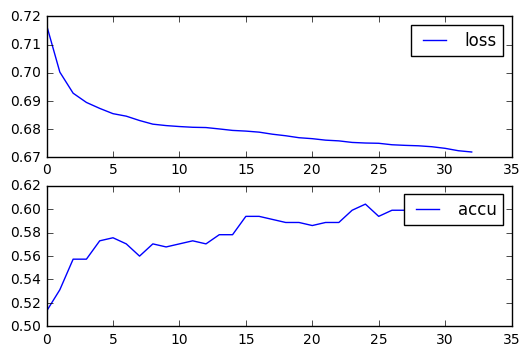

In [6]:
def train_model():
    model_dir = '/home/'+getpass.getuser()+'/git_test/test_data/models/'
    data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/hasRing/data/'
    color_mode = 'grayscale' # 'grayscale', 'rgb'
    batch_size = 32
    nb_train_samples = 860
    nb_validation_samples = 384
    nb_epoch = 33

    X_train, y_train, X_validation, y_validation = prepare_data(data_dir, color_mode, batch_size)

    print X_train.shape, y_train.shape
    print X_validation.shape, y_validation.shape

    history = LossHistory()
    checkpointer = ModelCheckpoint(filepath=model_dir+'mlp_weights.hdf5', 
                                   verbose=1, save_best_only=True)
    model = build_model()
    model = build_model()
    config = model.to_json()
    json.dump(config, open(model_dir+'mlp_config.json', 'w'))

    model.fit(X_train, y_train, nb_epoch=nb_epoch, callbacks=[history, checkpointer],
              validation_data=(X_validation, y_validation))

    loss = [x[2] for x in history.records]
    accu = [x[3] for x in history.records]
    plt.figure()
    plt.subplot(211)
    plt.plot(range(len(loss)), loss, label='loss')
    plt.legend()
    plt.subplot(212)
    plt.plot(range(len(accu)), accu, label='accu')
    plt.legend()

    plt.show()

train_model()

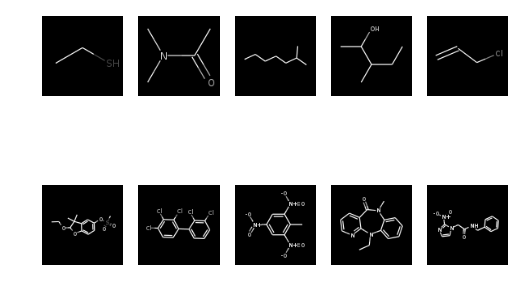

In [5]:
import os
import keras.backend as K
from Teemo.algorithm.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

data_dir = '/home/'+getpass.getuser()+'/git_test/test_data/examples/hasRing/data/'
dir_class_0 = data_dir + 'train/class_0/'
dir_class_1 = data_dir + 'train/class_1/'
n_cols = 5
class_0_list = os.listdir(dir_class_0)[:n_cols]
class_1_list = os.listdir(dir_class_1)[:n_cols]

plt.figure()
for ii, f in enumerate(class_0_list):
    f = dir_class_0 + f
    img = Image.open(f)
    arr = image.img_to_array(img)[0, :, :]
    plt.subplot(2,n_cols,ii+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

for ii, f in enumerate(class_1_list):
    f = dir_class_1 + f
    img = Image.open(f)
    arr = image.img_to_array(img)[0, :, :]
    plt.subplot(2,n_cols,ii+n_cols+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.show()